#Threshold / Outlier Detection using Firefly Algorithm (FA)

## Problem statement
Detecting anomalies (extreme-quality wines) in the UCI Wine Quality dataset using heuristic search — the Firefly Algorithm (FA). We search for feature weights and a score threshold that maximize anomaly (rare extremes) detection performance measured by F1 / average precision while encouraging sparse (interpretable) weights.

**Anomalies definition used here: quality <= 3 or quality >= 8 (rare extremes).**

## Imports

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, confusion_matrix
from scipy.linalg import pinv
import time
import math
import os

In [41]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [42]:
# ## 2. Configuration Parameters

CSV_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
LOCAL_CSV = "winequality-red.csv"

N_FIREFLIES = 80
GENERATIONS = 60
ALPHA = 0.65
ALPHA_DECAY = 0.997
BETA0 = 1.0
GAMMA = 0.6
SPARSITY_PENALTY = 0.05

N_SPLITS = 5  # for cross‑validation

LOW_QUALITY_THRESHOLD = 3
HIGH_QUALITY_THRESHOLD = 8

## Utilities: data loading, labelling, scoring, evaluation

In [43]:
# ## 3. Data Loading & Labeling Anomalies

def load_wine_data():
    try:
        df = pd.read_csv(CSV_URL, sep=';')
        print("Loaded CSV from URL.")
    except Exception as e:
        print("URL load failed:", e)
        if os.path.exists(LOCAL_CSV):
            df = pd.read_csv(LOCAL_CSV, sep=';')
            print("Loaded CSV from local file.")
        else:
            raise RuntimeError("Could not load dataset.")
    return df

def label_anomalies(df):
    q = df['quality'].values
    anomalies = ((q <= LOW_QUALITY_THRESHOLD) | (q >= HIGH_QUALITY_THRESHOLD)).astype(int)
    return anomalies

df = load_wine_data()
print("Data shape:", df.shape)
y = label_anomalies(df)
print("Anomaly class counts:", np.bincount(y))
X_raw = df.drop(columns=['quality']).values
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)


Loaded CSV from URL.
Data shape: (1599, 12)
Anomaly class counts: [1571   28]


In [48]:
# ## 4. Scoring & Evaluation Functions

def compute_weighted_mahalanobis_scores(X, weights):
    Xw = X * weights[np.newaxis, :]
    mu = Xw.mean(axis=0)
    cov = np.cov(Xw, rowvar=False)
    cov += np.eye(cov.shape[0]) * 1e-6
    invcov = pinv(cov)
    dif = Xw - mu
    return np.sum(dif.dot(invcov) * dif, axis=1)

def evaluate_threshold_scores(y_true, scores, perc_thr):
    min_anomalies = max(1, int(0.01 * len(y_true)))
    sorted_scores = np.sort(scores)
    thr_idx = max(len(sorted_scores) - min_anomalies, 0)
    threshold = sorted_scores[thr_idx] if perc_thr >= 0.95 else np.percentile(scores, perc_thr*100.0)

    preds = (scores > threshold).astype(int)
    precision = precision_score(y_true, preds, zero_division=0)
    recall = recall_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)
    roc_auc = roc_auc_score(y_true, scores) if len(np.unique(y_true))>1 else np.nan
    avg_prec = average_precision_score(y_true, scores) if len(np.unique(y_true))>1 else np.nan
    return {'threshold_value': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'avg_prec': avg_prec,
            'preds': preds}


## Firefly Algorithm class

The FA searches a vector of length d+1 where the first d entries are feature weights in [0,1] and the last entry is the percentile threshold in [0,1]. The fitness uses cross-validated F1 + AP + ROC contributions and a sparsity penalty.

In [49]:
class FireflyFA:
    def __init__(self, X, y, n_fireflies=N_FIREFLIES, generations=GENERATIONS, alpha=ALPHA, beta0=BETA0, gamma=GAMMA):
        self.X = X  # standardized features numpy array
        self.y = y  # binary anomaly labels
        self.n, self.d = X.shape
        self.n_fireflies = n_fireflies
        self.generations = generations
        self.alpha = alpha
        self.beta0 = beta0
        self.gamma = gamma

        # each firefly: vector length d+1 in [0,1]
        self.dim = self.d + 1

        # initialization
        self.population = np.random.rand(n_fireflies, self.dim)
        self.fitness = np.zeros(n_fireflies)
        self.history_best = []
        self.best_solution = None
        self.best_fitness = -np.inf

    def position_to_params(self, position):
        weights = position[:self.d]
        thr = position[self.d]  # percentile [0,1]
        return weights, thr

    def fitness_of(self, position):
        """Compute CV fitness (mean F1 across folds) minus small sparsity penalty"""
        weights, thr = self.position_to_params(position)
        skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
        f1s = []
        rocs = []
        aps = []
        for train_idx, val_idx in skf.split(self.X, self.y):
            X_train, X_val = self.X[train_idx], self.X[val_idx]
            y_train, y_val = self.y[train_idx], self.y[val_idx]
            # compute scores on validation using distribution from train
            # fit using training statistics:
            # compute weighted mahalanobis on train (to get mu and cov)
            Xw_train = X_train * weights[np.newaxis, :]
            mu = Xw_train.mean(axis=0)
            cov = np.cov(Xw_train, rowvar=False)
            cov += np.eye(cov.shape[0]) * 1e-6
            invcov = pinv(cov)
            # compute scores for validation
            Xw_val = X_val * weights[np.newaxis, :]
            dif = Xw_val - mu
            left = dif.dot(invcov)
            scores_val = np.sum(left * dif, axis=1)
            # evaluate threshold
            metrics = evaluate_threshold_scores(y_val, scores_val, thr)
            f1s.append(metrics['f1'])
            rocs.append(metrics['roc_auc'])
            aps.append(metrics['avg_prec'])
        mean_f1 = np.mean(f1s)
        mean_roc = np.nanmean(rocs)
        mean_ap = np.nanmean(aps)
        # sparsity penalty: average weight magnitude (we want small weights)
        sparsity = np.mean(weights)
        # combine: we want to maximize F1 primarily, then AP, then penalize large weights
        score = 0.6*mean_f1 + 0.3*mean_ap + 0.1*(mean_roc if not math.isnan(mean_roc) else 0.0) - SPARSITY_PENALTY*sparsity
        return score

    def run(self, verbose=True):
        # init fitness
        for i in range(self.n_fireflies):
            self.fitness[i] = self.fitness_of(self.population[i])
        idx = np.argsort(-self.fitness)
        self.population = self.population[idx]
        self.fitness = self.fitness[idx]
        self.best_fitness = self.fitness[0]
        self.best_solution = self.population[0].copy()
        if verbose:
            print(f"Initial best fitness: {self.best_fitness:.4f}")

        # main loop
        for gen in range(self.generations):
            for i in range(self.n_fireflies):
                for j in range(self.n_fireflies):
                    if self.fitness[j] > self.fitness[i]:
                        # move firefly i towards j
                        rij = np.linalg.norm(self.population[i] - self.population[j])
                        beta = self.beta0 * np.exp(-self.gamma * (rij ** 2))
                        # deterministic move + randomization
                        rand_vec = np.random.rand(self.dim) - 0.5
                        self.population[i] = self.population[i] * (1 - beta) + self.population[j] * beta + self.alpha * rand_vec
                        # clamp to [0,1]
                        self.population[i] = np.clip(self.population[i], 0.0, 1.0)
                        # evaluate new fitness
                        new_fit = self.fitness_of(self.population[i])
                        if new_fit > self.fitness[i]:
                          self.fitness[i] = new_fit
                          if new_fit > self.best_fitness:
                              self.best_fitness = new_fit
                              self.best_solution = self.population[i].copy()
            # optional alpha decay
            self.alpha *= 0.995

            # sort by fitness descending
            idx = np.argsort(-self.fitness)
            self.population = self.population[idx]
            self.fitness = self.fitness[idx]
            if self.fitness[0] > self.best_fitness:
                self.best_fitness = self.fitness[0]
                self.best_solution = self.population[0].copy()
            self.history_best.append(self.best_fitness)
            if verbose and (gen % max(1, (self.generations // 10)) == 0):
                print(f"Gen {gen+1:3d}/{self.generations}  best_fitness={self.best_fitness:.4f}  alpha={self.alpha:.4f}")


        if verbose:
            print("FA finished. Best fitness:", self.best_fitness)
        return self.best_solution, self.best_fitness, self.history_best

In [50]:
import time
t0 = time.time()
X_raw = df.drop(columns=['quality']).values
y_anom = label_anomalies(df)

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

## Main

Loaded CSV from URL.
Initial best fitness: 0.1234
Gen   1/60  best_fitness=0.1555  alpha=0.6468
Gen   7/60  best_fitness=0.1669  alpha=0.6276
Gen  13/60  best_fitness=0.1669  alpha=0.6090
Gen  19/60  best_fitness=0.1669  alpha=0.5910
Gen  25/60  best_fitness=0.1669  alpha=0.5734
Gen  31/60  best_fitness=0.1710  alpha=0.5565
Gen  37/60  best_fitness=0.1710  alpha=0.5400
Gen  43/60  best_fitness=0.1710  alpha=0.5240
Gen  49/60  best_fitness=0.1710  alpha=0.5084
Gen  55/60  best_fitness=0.1710  alpha=0.4934
FA finished. Best fitness: 0.17104103063228404
Best threshold percentile (0..1): 0.9483470609693732
Best weights (first 6): [1.         0.20169558 0.         0.         0.08399913 0.2719225 ]

--- Final Test Metrics ---
Threshold value (score): 18.80599
Precision: 0.0000
Recall:    0.0000
F1:        0.0000
ROC AUC:   0.7781
Avg Prec:  0.0491

Confusion Matrix (rows=true, cols=pred):
[[297  17]
 [  6   0]]


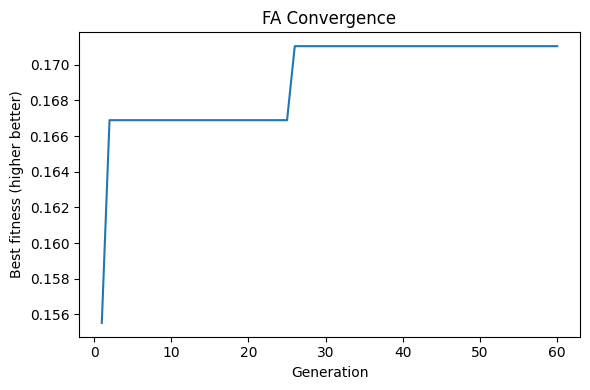

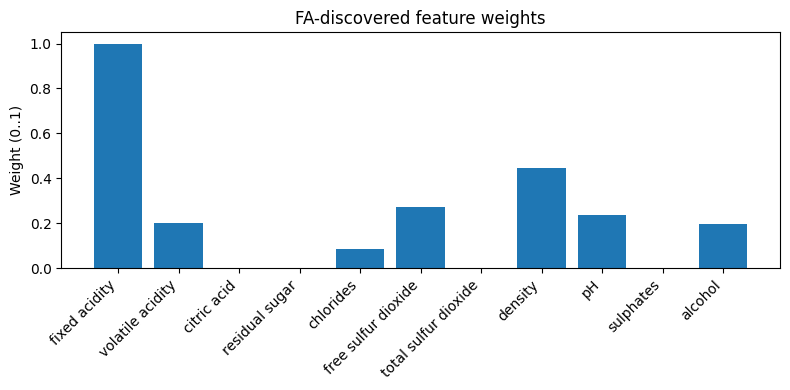

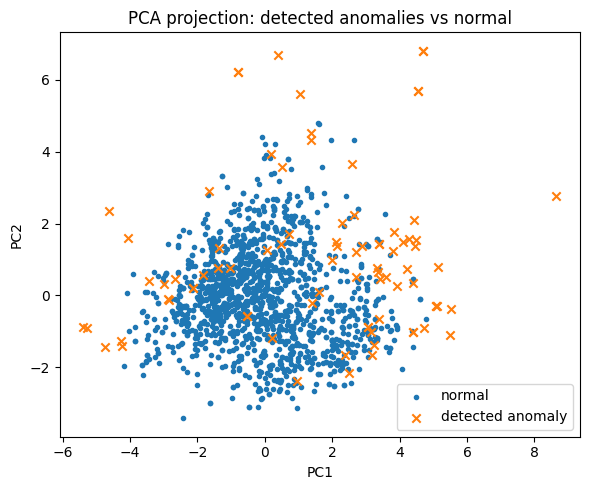

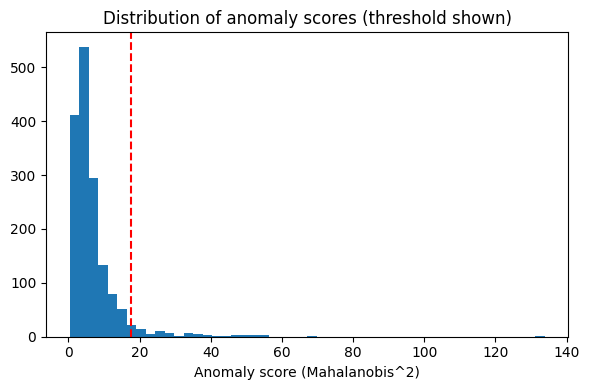

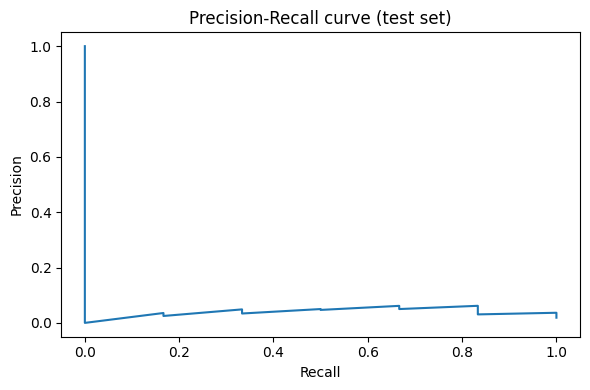

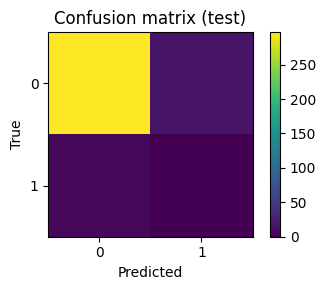


Total runtime: 8751.4 sec


In [51]:
def main():
    t0 = time.time()
    df = load_wine_data()

    # standardize
    scaler = StandardScaler()
    X = scaler.fit_transform(X_raw)

    # run FA
    fa = FireflyFA(X, y_anom, n_fireflies=N_FIREFLIES, generations=GENERATIONS, alpha=ALPHA, beta0=BETA0, gamma=GAMMA)
    best_pos, best_fit, hist = fa.run(verbose=True)
    best_weights, best_thr = fa.position_to_params(best_pos)
    print("Best threshold percentile (0..1):", best_thr)
    print("Best weights (first 6):", best_weights[:6])

    # Evaluate final solution on a held-out test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_anom, test_size=0.2, random_state=RANDOM_SEED, stratify=y_anom)
    # compute train stats
    Xw_train = X_train * best_weights[np.newaxis, :]
    mu = Xw_train.mean(axis=0)
    cov = np.cov(Xw_train, rowvar=False) + np.eye(X.shape[1]) * 1e-6
    invcov = pinv(cov)
    # test scores
    dif = (X_test * best_weights[np.newaxis, :]) - mu
    left = dif.dot(invcov)
    scores_test = np.sum(left * dif, axis=1)
    metrics_test = evaluate_threshold_scores(y_test, scores_test, best_thr)

    print("\n--- Final Test Metrics ---")
    print(f"Threshold value (score): {metrics_test['threshold_value']:.5f}")
    print(f"Precision: {metrics_test['precision']:.4f}")
    print(f"Recall:    {metrics_test['recall']:.4f}")
    print(f"F1:        {metrics_test['f1']:.4f}")
    print(f"ROC AUC:   {metrics_test['roc_auc']:.4f}")
    print(f"Avg Prec:  {metrics_test['avg_prec']:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, metrics_test['preds'])
    print("\nConfusion Matrix (rows=true, cols=pred):")
    print(cm)


    # Visualizations
    # 1) FA convergence plot
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(hist)+1), hist)
    plt.xlabel("Generation")
    plt.ylabel("Best fitness (higher better)")
    plt.title("FA Convergence")
    plt.tight_layout()
    plt.show()

    # 2) Feature weights bar chart (with original column names)
    feature_names = df.drop(columns=['quality']).columns.tolist()
    plt.figure(figsize=(8,4))
    plt.bar(range(len(best_weights)), best_weights)
    plt.xticks(range(len(best_weights)), feature_names, rotation=45, ha='right')
    plt.ylabel("Weight (0..1)")
    plt.title("FA-discovered feature weights")
    plt.tight_layout()
    plt.show()

    # 3) PCA 2D projection with anomalies highlighted
    from sklearn.decomposition import PCA
    scores_all = compute_weighted_mahalanobis_scores(X, best_weights)
    threshold_val = np.percentile(scores_all, best_thr*100.0)
    preds_all = (scores_all > threshold_val).astype(int)
    pca = PCA(n_components=2, random_state=RANDOM_SEED)
    pcs = pca.fit_transform(X)
    plt.figure(figsize=(6,5))
    # plot normal vs anomaly
    idx_norm = np.where(preds_all==0)[0]
    idx_anom = np.where(preds_all==1)[0]
    plt.scatter(pcs[idx_norm,0], pcs[idx_norm,1], marker='.', label='normal')
    plt.scatter(pcs[idx_anom,0], pcs[idx_anom,1], marker='x', label='detected anomaly')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA projection: detected anomalies vs normal")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 4) Score histogram with threshold line
    plt.figure(figsize=(6,4))
    plt.hist(scores_all, bins=50)
    plt.axvline(threshold_val, linestyle='--', color='r', label='Threshold')
    plt.xlabel("Anomaly score (Mahalanobis^2)")
    plt.title("Distribution of anomaly scores (threshold shown)")
    plt.tight_layout()
    plt.show()

    # 5) Precision-Recall curve using test split (use scores_test)
    from sklearn.metrics import precision_recall_curve
    prec, rec, thr_pr = precision_recall_curve(y_test, scores_test)
    plt.figure(figsize=(6,4))
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall curve (test set)")
    plt.tight_layout()
    plt.show()

    # 6) Confusion matrix heatmap (basic)
    plt.figure(figsize=(4,3))
    plt.imshow(cm, interpolation='nearest')
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion matrix (test)")
    plt.xticks([0,1])
    plt.yticks([0,1])
    plt.tight_layout()
    plt.show()

    t1 = time.time()
    print(f"\nTotal runtime: {t1 - t0:.1f} sec")

if __name__ == "__main__":
    main()